<a href="https://colab.research.google.com/github/tawfiqam/MI564/blob/main/Word2Vec_Intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Word2vec is a tool that creates word embeddings: given an input text, it will create a vector representation of each word. Word2vec was originally implemented at Google by Tomáš Mikolov; et. al. but nowadays you can find lots of other implementations.

To create word embeddings, word2vec uses a neural network with a single hidden layer. The input is each word, along with a configurable context (typically 5 to 10 words). You’d train this neural network to either predict the word from its context or the other way around (predict the context from the word). This depends on the training mode, but let’s illustrate the first approach: say you have the word solr out of introduction to solr, and we’re trying to predict it with three neurons:

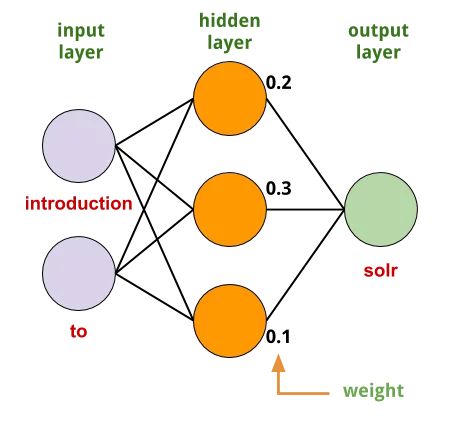

Most implementations allow you to choose between two training modes: continuous bag of words (CBOW) and continuous skip-gram. With CBOW you predict the word from the context, like in the figure above. With skip-gram you predict the context from the word. We don’t care about the predictions here, because we don’t use word2vec to predict either. Instead, when training is done, word2vec takes the weights of the hidden layer neurons for each word. In the figure above, we have [0.2, 0.3, 0.1] for the word solr. These weights are the vectors we’re looking for: the generated word embeddings.

If all goes well, word embeddings capture the semantics of each word pretty well. That’s because we assume that the context typically defines the word, which is true for most use-cases. For example, “Intel CPU, 16GB of RAM” and “Intel processor, 16GB of RAM” will create similar embeddings for CPU and processor. That said, sometimes the surrounding words don’t provide enough information, or that information could be misleading. For example, “this tool rocks” and “this tool stinks” will make rocks similar to stinks.

Still, if embeddings do capture the semantics to a reasonable level, you could use them for:

1. dynamic synonym expansion. If someone is searching for CPU, you may want to include processor in the query. This is what we aimed to do in our demo at Activate.
2. use distance between vectors to measure similarity. If we come up with a good way to squash multiple word vectors into one (averaging is the simplest option), then we can compare squashed vectors from the query string with squashed vectors from the document string. The cosine similarity of the two vectors could be a relevancy score. Or at least a component of it. At Activate, there were a few talks exploring this idea (examples here and here).
3. classification or clustering. If vectors of two words are closer (by cosine similarity), they are more likely to belong to the same group. The original implementation of word2vec also allows you to cluster words using K-means

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size':20,'figure.figsize':(10,8)})

In [ ]:
import pandas as pd
#we will need datetime in order to specify the timeline we need to collect the data
import datetime as dt
#regular expressions will help us clean the text
import re
#gensim
import gensim
#LDA model
from gensim.models import LdaModel
#Use this to setup a dictionay
from gensim.corpora import Dictionary
#This will allow us to get the coherence models
from gensim.models import CoherenceModel
#gensim is a python library used mostly for NLP analysis
#corpora allows us to build a corpus out of different 
#documents
from gensim import corpora
#Defaultdict is a container like dictionaries present in the module collections. 
#Defaultdict is a sub-class of the dict class that returns a dictionary-like object. 
#The functionality of both dictionaries and defualtdict are almost same except for 
#the fact that defualtdict never raises a KeyError. It provides a default value 
#for the key that does not exists.
from collections import defaultdict

#importing ntlk
#we will be using nltk to create bag of words
import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import RegexpTokenizer
#this recognizes where a sentence starts & ends
#http://www.nltk.org/_modules/nltk/tokenize/punkt.html
nltk.download('punkt')
#Wordnet is important for Lemmatization ==> seel later when we dig into this
#https://www.nltk.org/howto/wordnet.html
nltk.download('wordnet')
#use nltk to get stopwords
nltk.download('stopwords')
#create a stoplist that includes all the english stop words
stopwords_english = stopwords.words('english')
display('here is a subset of the stop words')
display(stopwords_english[0:10])
#now we import the wrapper in order to use the API
# Text Cleaning
import string

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


'here is a subset of the stop words'

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

Lemmatization is the process of grouping together the inflected forms of a word so they can be analysed as a single item. For example, if we are looking through a document and want to do topic modeling, it is important that we do not see each inflection of the word differently. That would confuse the topic modeling algorithm. So, for example, we'd want to see the words "studies" "studied" and "studying" as "study." [1,2]




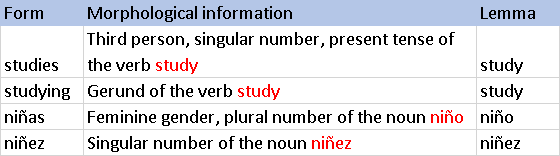

Another simpler way of doing this is called stemming. Stemming algorithms work by cutting off the end or the beginning of the word, taking into account a list of common prefixes and suffixes that can be found in an inflected word. This indiscriminate cutting can be successful in some occasions, but not always, and that is why we affirm that this approach presents some limitations.

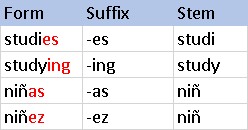

References:

[1] https://en.wikipedia.org/wiki/Lemmatisation

[2] [https://blog.bitext.com what-is-the-difference-between-stemming-and-lemmatization/]()

In [ ]:
#We are using nltk lemmatizer 
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

##Cleaning text and creating documents

In [ ]:
#creating smaller dataframe
#we do not need all the columns
df = pd.read_csv('simpsons_dataset.csv')

In [ ]:
df.head()

,raw_character_text,spoken_words
0,Miss Hoover,"No, actually, it was a little of both. Sometim..."
1,Lisa Simpson,Where's Mr. Bergstrom?
2,Miss Hoover,I don't know. Although I'd sure like to talk t...
3,Lisa Simpson,That life is worth living.
4,Edna Krabappel-Flanders,The polls will be open from now until the end ...


In [ ]:
def clean_pass(text): 
    #make string lowercase 
    text = str(text)
    text = text.lower()

    #tokenize
    #create bag of words
    #1-grams 
    tokens = nltk.word_tokenize(text) 
    clean_text = []
    
    #remove stopwords, puncuation, then lemmatize
    for word in tokens:
        if (word not in stopwords_english and word not in string.punctuation): 
            token = wordnet_lemmatizer.lemmatize(word)
            clean_text.append(token)
            
    #remove words of length 3 or smaller        
    clean_text = [token for token in clean_text if len(token) > 2] 
            
    return clean_text      

In [ ]:
df['clean_text'] = df.spoken_words.apply(clean_pass)

In [ ]:
df.clean_text

0         [actually, little, sometimes, disease, magazin...
1                                          [mr., bergstrom]
2         [n't, know, although, sure, like, talk, n't, t...
3                                     [life, worth, living]
4         [poll, open, end, recess, case, decided, put, ...
                                ...                        
158309                                               [back]
158310             [see, class, lyme, disease, turned, ...]
158311                                  [psy-cho-so-ma-tic]
158312                                        [mean, crazy]
158313                                       [mean, faking]
Name: clean_text, Length: 158314, dtype: object

In [ ]:
'''
Parameters:
**********
**********

min_count:  

size:

window:

workers:
'''




from gensim.models import Word2Vec
model = Word2Vec(df.clean_text.values, min_count=5,size=300,workers=6, window=5)

In [ ]:
model.most_similar('homer')

[('marge', 0.9019104242324829),
 ('bart', 0.8629046082496643),
 ('abe', 0.8581472039222717),
 ('lisa', 0.8486896753311157),
 ('bartholomew', 0.7806746959686279),
 ('abraham', 0.7720190286636353),
 ('monty', 0.7631305456161499),
 ('mrs.', 0.7594013810157776),
 ('eliza', 0.7529336810112),
 ('gene', 0.7526600360870361)]

In [ ]:
model.most_similar('beer')

[('drink', 0.9029555320739746),
 ('gim', 0.8928136825561523),
 ('hand', 0.8804429769515991),
 ('foot', 0.8709589242935181),
 ('car', 0.8700552582740784),
 ('gun', 0.8589096069335938),
 ('seat', 0.8571950197219849),
 ('cold', 0.8512172698974609),
 ('butt', 0.8456505537033081),
 ('shake', 0.8403935432434082)]

In [ ]:
model.most_similar('marge')

[('homer', 0.9019104242324829),
 ('bart', 0.8495965600013733),
 ('abe', 0.8375353813171387),
 ('lisa', 0.8322593569755554),
 ('grampa', 0.8264575004577637),
 ('homie', 0.8222485184669495),
 ('son', 0.808549165725708),
 ('sweetie', 0.8071724772453308),
 ('honey', 0.8061093091964722),
 ('everyone', 0.7971636652946472)]

In [ ]:
model.most_similar('bart')

[('lisa', 0.9657636880874634),
 ('homer', 0.8629046082496643),
 ('marge', 0.8495965600013733),
 ('abe', 0.806566596031189),
 ('grampa', 0.7904402017593384),
 ('maggie', 0.7654160261154175),
 ('honey', 0.7651635408401489),
 ('homie', 0.7616552114486694),
 ('milhouse', 0.7573463916778564),
 ('sweetie', 0.7559143900871277)]

In [ ]:
model.similarity("maggie", "baby")

0.7721968

In [ ]:
model.doesnt_match(['homer', 'patty', 'selma'])

/usr/local/lib/python3.7/dist-packages/gensim/models/keyedvectors.py:895: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


'homer'

In [ ]:
model.doesnt_match(['jimbo', 'milhouse', 'kearney'])

/usr/local/lib/python3.7/dist-packages/gensim/models/keyedvectors.py:895: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


'milhouse'

In [ ]:
model.most_similar(positive=["man", "homer"], negative=["marge"], topn=10)

[('young', 0.6950331330299377),
 ('lady', 0.6751543283462524),
 ('old', 0.6593189835548401),
 ('montgomery', 0.6241269707679749),
 ('sideshow', 0.598603367805481),
 ('monty', 0.598003625869751),
 ('people', 0.5977216362953186),
 ('mr.', 0.59765625),
 ('evil', 0.5890920162200928),
 ('evening', 0.5853491425514221)]

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
 
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.manifold import TSNE

In [ ]:
all_vocab = list(model.wv.vocab.keys())
data_dict = {word: model[word] for word in all_vocab}
result = pd.DataFrame(data=data_dict).transpose()

In [ ]:
result.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
actually,0.006313,0.016310,0.232114,0.001385,-0.067428,-0.172965,-0.156326,0.018704,0.028029,0.104145,-0.224747,-0.073816,0.106454,0.104170,0.315723,-0.159572,-0.052250,0.023703,0.091001,-0.102943,-0.000351,0.204034,-0.250252,-0.028603,-0.296826,0.067011,-0.182148,0.125596,-0.438325,0.120004,0.246554,-0.034954,0.155993,-0.018259,-0.054253,0.338996,0.160885,0.158156,-0.095317,0.206221,...,-0.030229,-0.068695,-0.012628,0.164356,0.076891,0.054761,-0.008439,0.088461,-0.206002,0.010409,0.003369,-0.221897,0.075641,0.038491,0.044125,0.125357,0.030749,0.087504,-0.099706,0.098216,0.060414,0.018469,-0.127277,-0.130390,-0.245717,0.006852,-0.173193,-0.071356,-0.045468,-0.043855,-0.003210,-0.046250,-0.129995,0.064595,-0.046023,0.137195,-0.027090,-0.093216,-0.048326,0.077233
little,0.147620,-0.102562,0.183986,-0.134165,0.362789,-0.124683,-0.149655,-0.131255,0.089501,-0.142271,0.197092,-0.301975,-0.298681,0.049547,-0.207779,0.046338,0.118309,-0.317911,0.023159,0.010813,-0.403669,0.303711,-0.171813,0.183184,0.037751,0.341024,-0.392039,0.203933,0.104162,-0.102649,0.120762,0.017816,-0.078864,-0.354923,-0.276779,0.485157,0.057212,0.266508,-0.156059,0.434462,...,-0.155774,0.581122,-0.147617,0.226858,0.023376,-0.004983,-0.377212,-0.304069,0.381407,-0.034394,-0.058140,0.785210,0.157635,0.392469,-0.241070,0.657110,-0.200569,0.261189,-0.021427,0.240398,0.040139,0.081182,-0.089472,-0.026335,-0.640366,-0.006010,-0.222865,0.161003,0.280754,-0.217549,-0.175328,0.348510,0.164082,-0.148879,-0.175421,-0.034024,0.160963,-0.406696,-0.245682,-0.102573
sometimes,0.018360,-0.023883,0.224290,-0.038749,0.019235,-0.241281,-0.106253,0.013784,0.111030,-0.034679,-0.278857,-0.019662,0.099079,0.136318,0.063415,-0.095198,0.092868,-0.091643,0.147109,0.021338,-0.060117,0.223883,-0.299155,-0.053988,-0.148802,0.100502,-0.178925,0.167858,-0.301535,0.173298,0.191042,-0.111325,0.223033,-0.142567,-0.108103,0.244151,0.285743,0.109549,-0.030223,0.202751,...,-0.022089,-0.058710,0.121409,0.110239,0.027179,0.082689,0.080178,0.154861,-0.237492,0.006189,0.189062,-0.212437,0.108072,0.015720,0.006636,0.133848,0.092713,0.147910,-0.022990,0.151736,0.099804,-0.012575,-0.158251,-0.147168,-0.256062,0.147038,-0.122867,0.019395,-0.030179,-0.029598,-0.111598,0.055218,-0.051537,-0.093352,-0.009750,0.118538,0.033784,-0.134654,-0.138874,0.009381
disease,0.106478,0.006085,0.187886,0.009748,0.078672,-0.059814,-0.069357,-0.057100,0.017621,-0.023258,-0.145143,-0.033601,0.081711,0.059015,0.159249,-0.094458,0.010408,-0.099267,-0.021029,0.060385,-0.094010,0.079161,-0.148429,-0.006503,-0.087184,0.060349,-0.029506,0.151737,-0.133548,0.100657,0.167726,-0.011992,0.139719,-0.032947,0.058552,0.180765,0.154336,0.088376,-0.042369,0.091392,...,-0.001950,-0.094950,0.114537,-0.003152,-0.004822,-0.032074,0.101117,0.197492,-0.217822,0.052559,0.081026,-0.200467,0.203439,-0.052391,0.011151,0.099383,-0.052631,0.032044,0.051557,0.109275,0.144215,0.075332,-0.046589,-0.120879,-0.107368,0.019908,-0.066942,-0.048038,-0.006460,-0.098916,-0.072716,-0.000485,-0.111981,0.024417,-0.038724,0.144597,-0.011528,-0.130740,-0.056901,0.009989
magazine,0.180501,0.016364,0.183323,0.107192,0.119265,-0.010376,-0.135818,-0.055760,-0.000890,0.007219,-0.186043,-0.046681,0.100563,0.028679,0.341033,-0.167494,-0.036517,-0.111723,-0.087950,0.107843,-0.126613,0.092410,-0.135033,0.057675,-0.108009,0.066402,0.013190,0.242837,-0.227879,0.079922,0.219552,0.036356,0.135258,0.044742,0.094077,0.234100,0.052639,0.132177,-0.083517,0.113211,...,-0.057011,-0.119987,0.064283,-0.017369,0.063805,-0.092358,0.113348,0.244176,-0.246291,0.112221,0.041867,-0.251224,0.250343,-0.058194,0.023004,0.168256,-0.118243,-0.039467,0.055301,0.094488,0.129401,0.106275,-0.015167,-0.178091,-0.087863,-0.057685,-0

In [ ]:
vocab = list(model.wv.vocab)
X = model[vocab]

In [ ]:
X

array([[ 0.00609587, -0.03540872,  0.17821124, ..., -0.08387132,
        -0.21229844,  0.03035425],
       [ 0.13049032, -0.09280252, -0.10673285, ..., -0.32203284,
        -0.13717054,  0.09784527],
       [-0.01466643, -0.08354337,  0.2566487 , ..., -0.11430653,
        -0.26620656,  0.02480589],
       ...,
       [ 0.00423418, -0.00816188,  0.02405996, ..., -0.02009643,
        -0.02128212,  0.0021422 ],
       [ 0.01202439,  0.00592115,  0.04157765, ..., -0.02562015,
        -0.01580822,  0.01016927],
       [ 0.01099243, -0.00746032,  0.03838663, ..., -0.0211611 ,
        -0.00689434, -0.01001261]], dtype=float32)

In [ ]:
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)

In [ ]:
df = pd.DataFrame(X_tsne, index=vocab, columns=['x', 'y'])

In [ ]:
df.head()

,x,y
actually,23.880192,-43.040607
little,19.476397,-27.484383
sometimes,24.955202,-38.317905
disease,-14.249572,-53.225677
magazine,11.662952,-71.288322


In [ ]:
def display_closestwords_tsnescatterplot(model, word):
    
    arr = np.empty((0,300), dtype='f')
    word_labels = [word]

    # get close words
    close_words = model.similar_by_word(word,topn=20)
    
    # add the vector for each of the closest words to the array
    arr = np.append(arr, np.array([model[word]]), axis=0)
    for wrd_score in close_words:
        wrd_vector = model[wrd_score[0]]
        word_labels.append(wrd_score[0])
        arr = np.append(arr, np.array([wrd_vector]), axis=0)
        
    # find tsne coords for 2 dimensions
    tsne = TSNE(n_components=2, random_state=0)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)

    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    # display scatter plot
    plt.scatter(x_coords, y_coords)

    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
    plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
    plt.show()


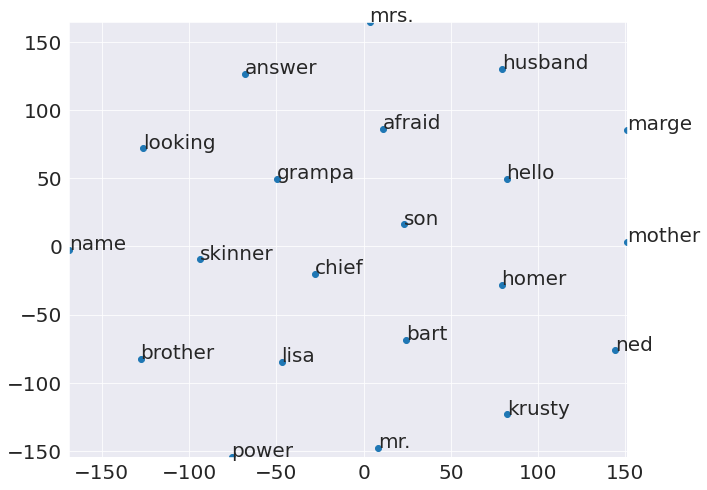

In [ ]:
display_closestwords_tsnescatterplot(model, 'homer')

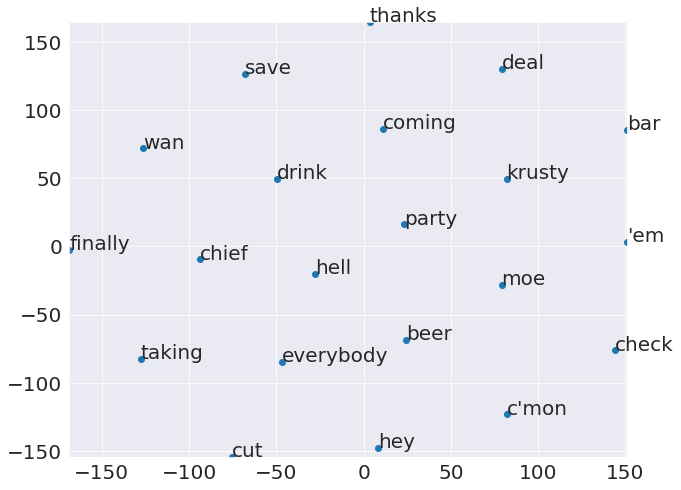

In [ ]:
display_closestwords_tsnescatterplot(model, 'moe')

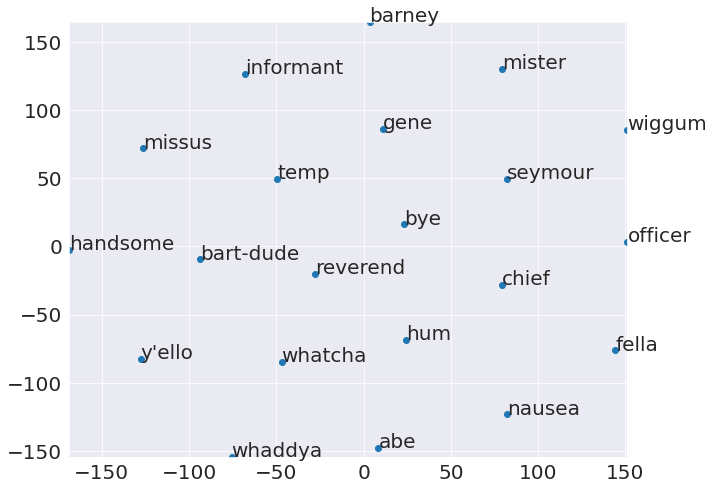

In [ ]:
display_closestwords_tsnescatterplot(model, 'chief')

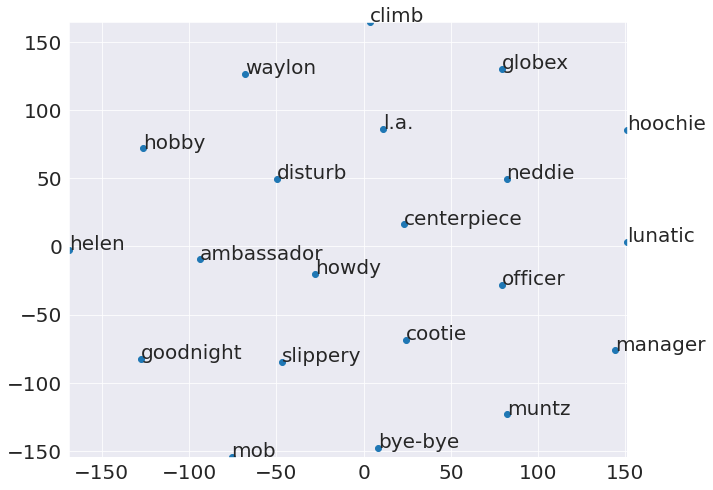

In [ ]:
display_closestwords_tsnescatterplot(model, 'officer')

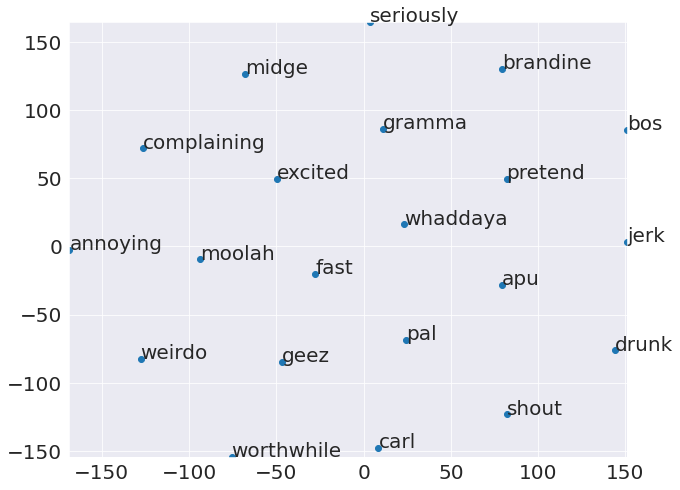

In [ ]:
display_closestwords_tsnescatterplot(model, 'apu')

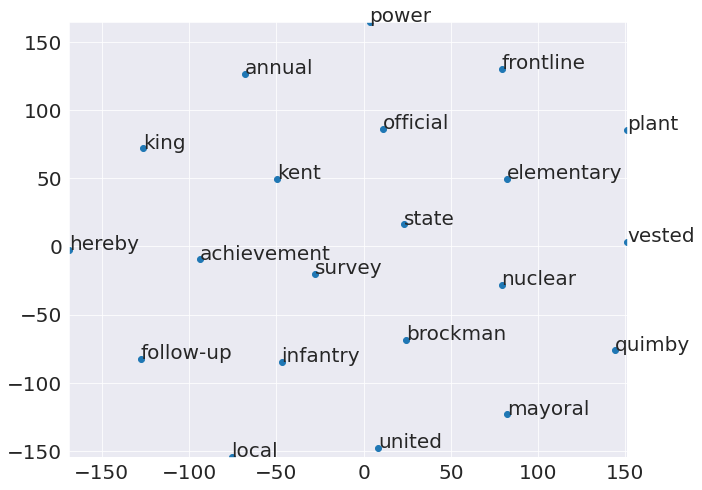

In [ ]:
display_closestwords_tsnescatterplot(model, 'nuclear')

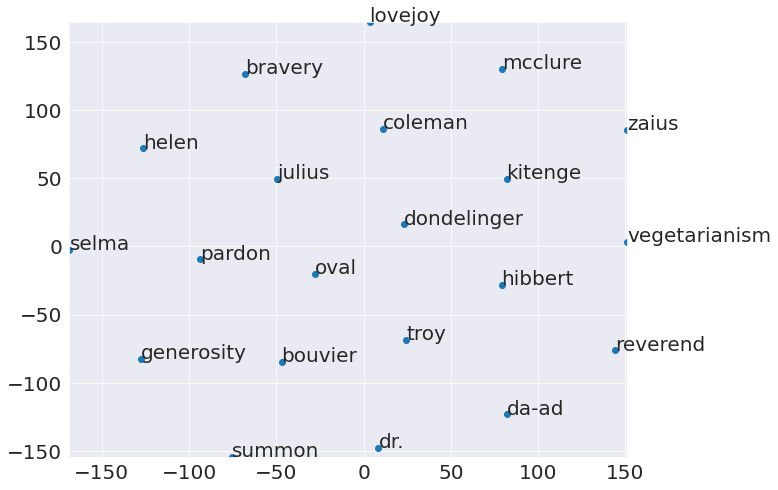

In [ ]:
display_closestwords_tsnescatterplot(model, 'hibbert')

In [ ]:
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

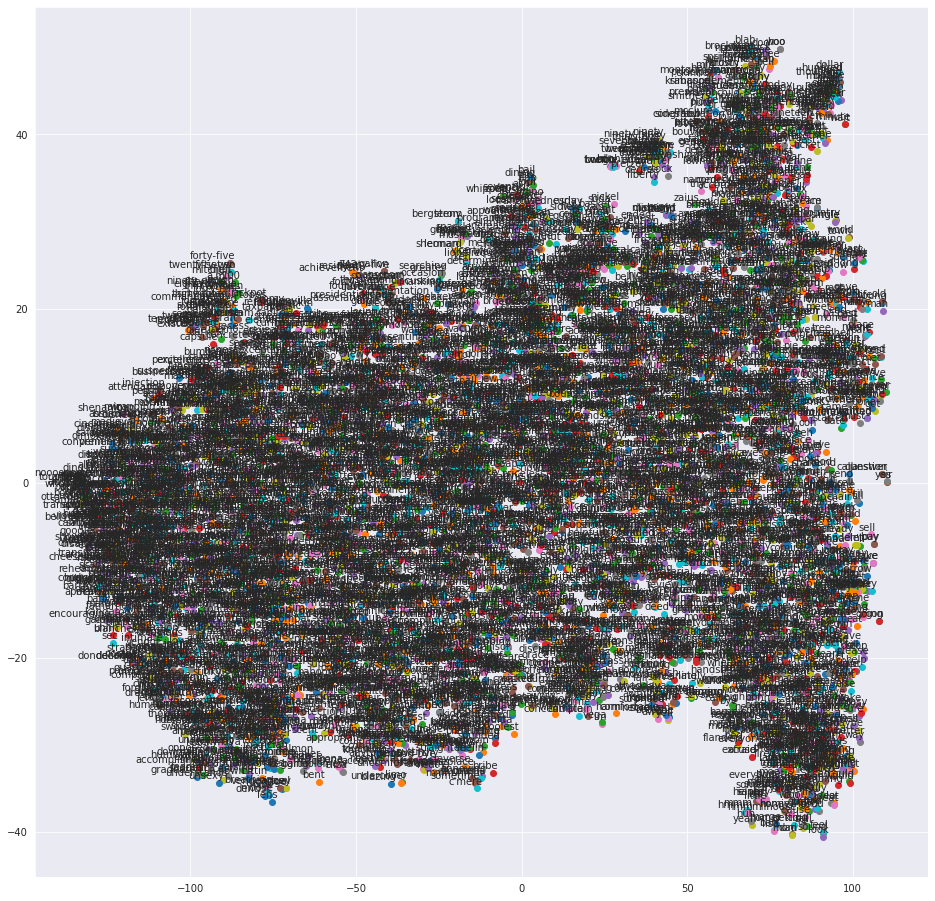

In [ ]:
tsne_plot(model)

In [ ]:
model = Word2Vec(df.clean_text.values, min_count=250,size=300,workers=6, window=5)

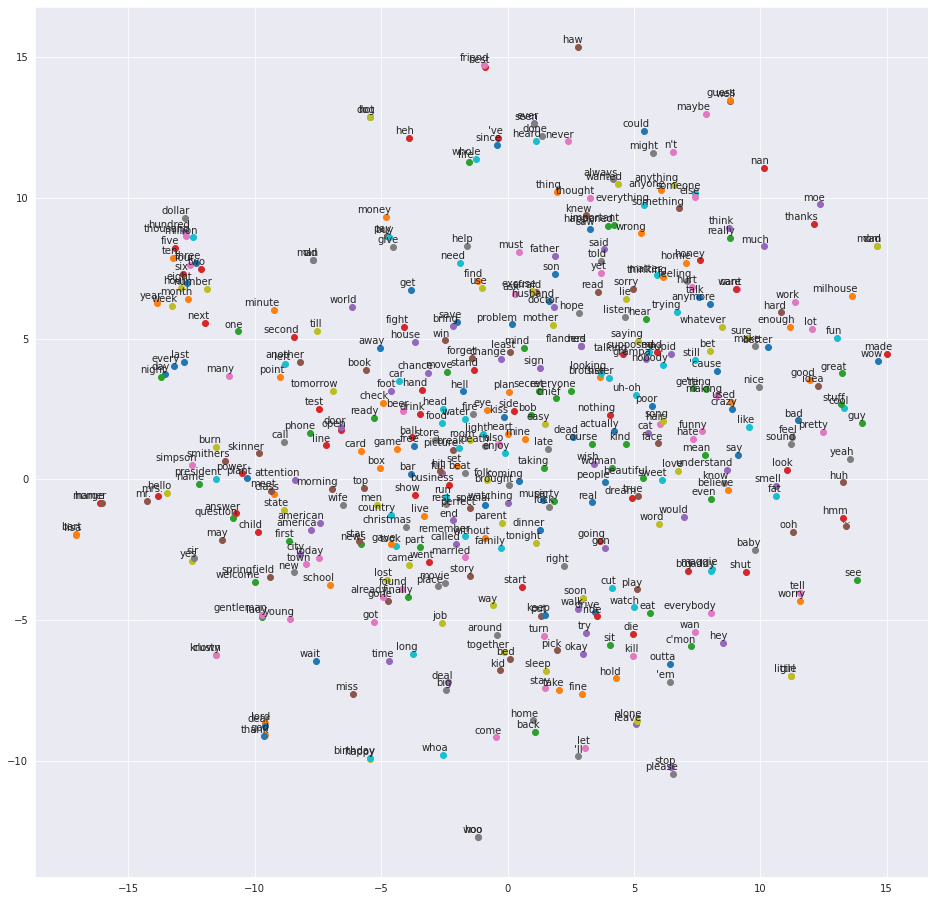

In [ ]:
tsne_plot(model)

In [ ]:
model = Word2Vec(df.clean_text.values, min_count=300,size=300,workers=6, window=5)

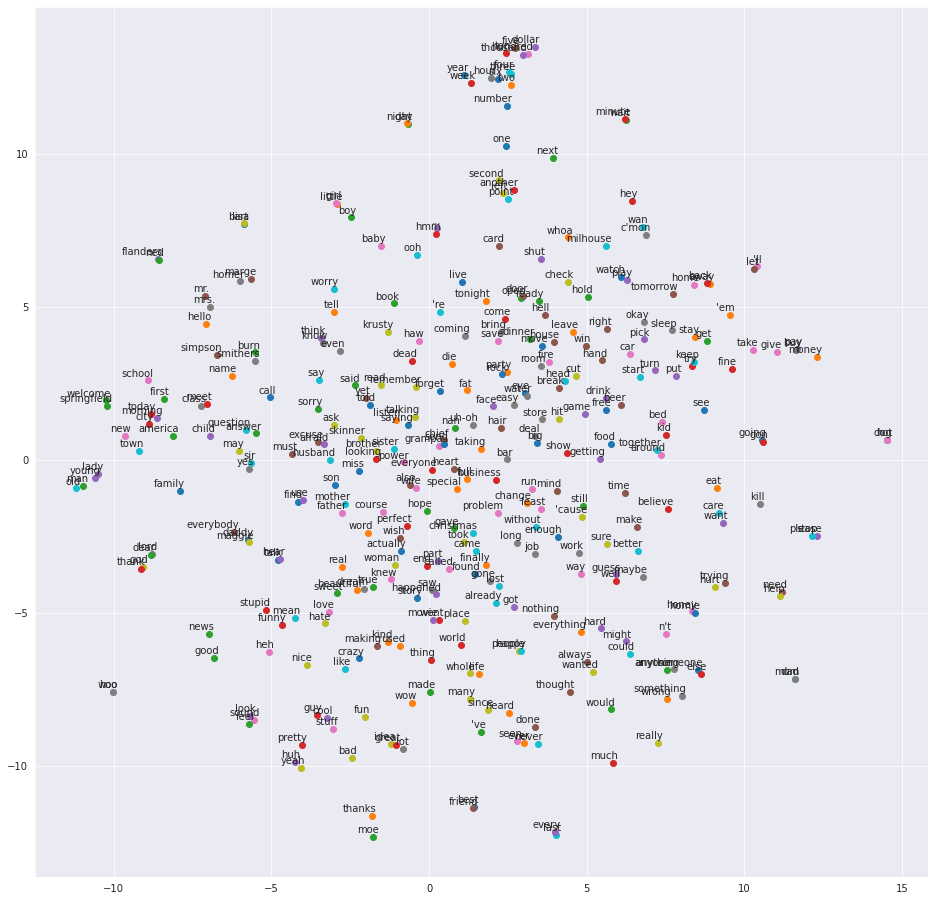

In [ ]:
tsne_plot(model)

In [ ]:
model = Word2Vec(df.clean_text.values, min_count=1000,size=300,workers=6, window=5)

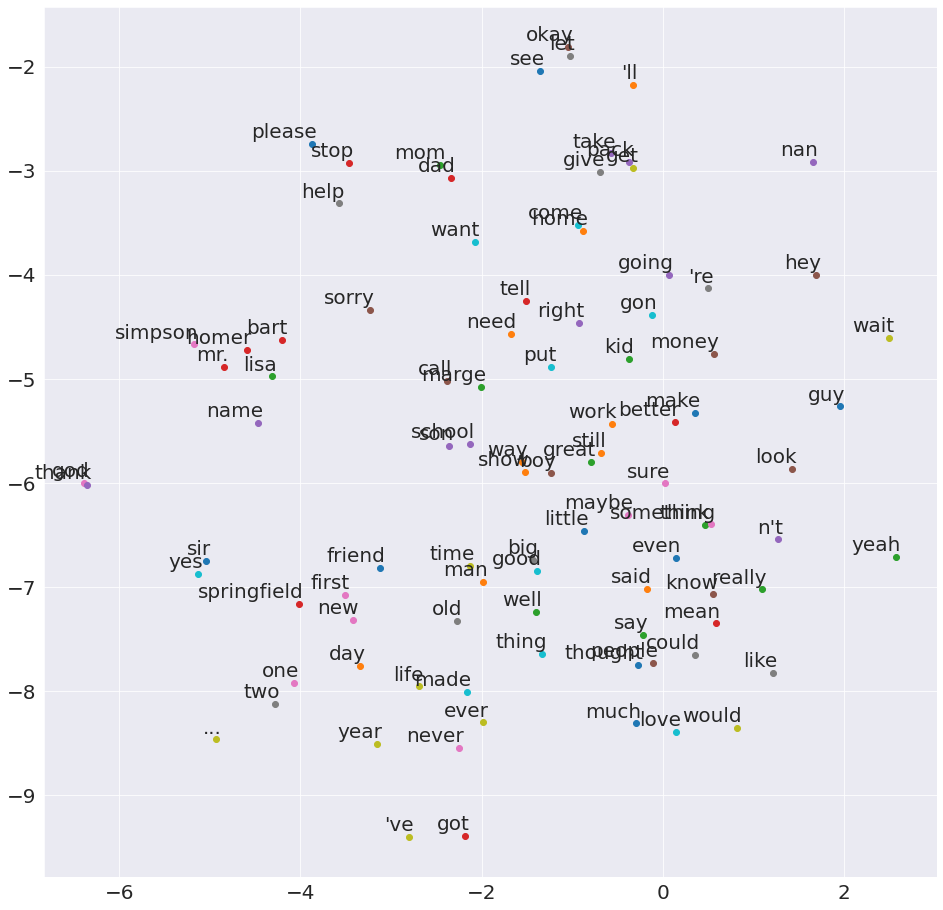

In [ ]:
tsne_plot(model)